# <center> Demand Forecasting with Amazon Forecast DeepAR </center>

---
### **Table of Contents**
1. Frame the Problem and Look at the Big Picture

2. Get the data

3. Data Exploration
   — Explore the data to gain insights
   
4. Amazon Forecast Workflow 


    4.1 Create Dataset  
    4.2 Create Dataset Group  
    4.3 Create Data Import Job  
    4.4 Create Predictor with customized Forecast horizon  
    4.5 Get Error Metrics  
    4.6 Create Forecast  
    4.7 Export Forecast to S3  
   
   
5. Present Solution
6. Cleanup
---

Dataset: https://www.kaggle.com/c/demand-forecasting-kernels-only/data  
AWS blog: https://aws.amazon.com/blogs/aws/amazon-forecast-now-generally-available/

In [1]:
# !pip install seaborn

In [1]:
import sys
import os
import time
import datetime
import pandas as pd
import boto3
import json

sys.path.insert( 0, os.path.abspath("common") )
import util

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
bucketName = "anderson-bucket-myown-test-dataset"
assert bucketName, "bucketName not set."

region = "us-west-2"
assert region, "region not set."

In [3]:
session = boto3.Session(region_name=region) 

forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

#### Configure IAM Role for Amazon Forecast

In [4]:
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-DeepArPlus"
role_arn = util.get_or_create_iam_role( role_name = role_name )

The role ForecastNotebookRole-DeepArPlus exists, ignore to create it
Attaching policies
Waiting for a minute to allow IAM role policy attachment to propagate
Done.


## 1. Frame the Problem and Look at the Big Picture

This is a Demand Forecasting task, where we are given 5 years (2013-1-1 to 2017-12-31)of daily sales as training data to forecast 3 months sales in 2018 (2018-1-1 to 2018-3-31).

But we will use 4 years of training data (2013-1-1 to 2016-12-31) for training and last year of training data  (2017-1-1 to 2017-12-31) for testing

## 2. Get the Data

Dataset: https://www.kaggle.com/c/demand-forecasting-kernels-only/data


In [10]:
#parse_dates transform string-type column to int-type
train = pd.read_csv('train.csv',header = 0,names= ["timestamp","store_id","item_id","demand"],parse_dates=['timestamp'],low_memory=False)
test = pd.read_csv('test.csv',header = 0,names= ["data_id","timestamp","store_id","item_id"], usecols = ["timestamp","store_id","item_id"],parse_dates=['timestamp'])

In [7]:
# s3 = session.client('s3')
# key="train_data.csv"
# s3.upload_file(Filename="train_csv.csv", Bucket=bucketName, Key=key)

## 3. Exploratory Data Analysis

In [9]:
print(train.shape)
print(train.describe())
train


(913000, 4)
            store_id        item_id         demand
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000


,timestamp,store_id,item_id,demand
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [9]:
print(test.shape)
print(test.describe())
test


(45000, 3)
           store_id      item_id
count  45000.000000  45000.00000
mean       5.500000     25.50000
std        2.872313     14.43103
min        1.000000      1.00000
25%        3.000000     13.00000
50%        5.500000     25.50000
75%        8.000000     38.00000
max       10.000000     50.00000


,timestamp,store_id,item_id
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1
...,...,...,...
44995,2018-03-27,10,50
44996,2018-03-28,10,50
44997,2018-03-29,10,50
44998,2018-03-30,10,50


In [10]:
daily_sales = train.groupby('timestamp', as_index=False)['demand'].sum()
store_daily_sales = train.groupby(['store_id', 'timestamp'], as_index=False)['demand'].sum()
item_daily_sales = train.groupby(['item_id', 'timestamp'], as_index=False)['demand'].sum()

In [11]:
daily_sales.head(5)

,timestamp,demand
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237


In [12]:
store_daily_sales.head(5)

,store_id,timestamp,demand
0,1,2013-01-01,1316
1,1,2013-01-02,1264
2,1,2013-01-03,1305
3,1,2013-01-04,1452
4,1,2013-01-05,1499


In [13]:
item_daily_sales.head(5)

,item_id,timestamp,demand
0,1,2013-01-01,133
1,1,2013-01-02,99
2,1,2013-01-03,127
3,1,2013-01-04,145
4,1,2013-01-05,149


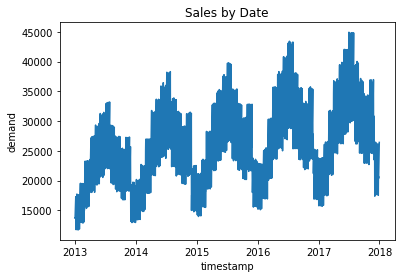

In [14]:
palette = sns.color_palette("mako_r", 6)
graph = sns.lineplot(data=daily_sales, x="timestamp", y="demand", palette=palette).set_title("Sales by Date")


In [15]:
pivot = store_daily_sales.pivot("timestamp", "store_id", "demand")
pivot.head(5)

store_id,1,2,3,4,5,6,7,8,9,10
timestamp,,,,,,,,,,
2013-01-01,1316,1742,1588,1423,1032,1099,964,1628,1383,1521
2013-01-02,1264,1808,1538,1432,997,1023,944,1687,1455,1530
2013-01-03,1305,1887,1635,1534,1130,1149,966,1736,1492,1654
2013-01-04,1452,1983,1741,1685,1258,1201,1040,1966,1612,1739
2013-01-05,1499,2087,1887,1649,1154,1286,1131,2005,1698,1841


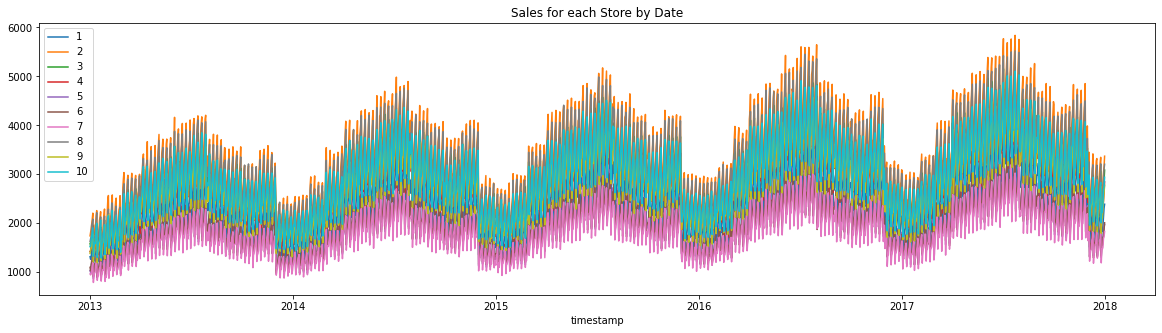

In [16]:
plt.figure(figsize=(20,5))
graph = sns.lineplot(data=pivot,dashes=False).set_title("Sales for each Store by Date")

In [17]:
pivot = item_daily_sales.pivot("timestamp", "item_id", "demand")
pivot.head(5)

item_id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01,133,327,172,102,83,288,278,416,245,378,...,103,195,253,154,396,319,116,277,159,330
2013-01-02,99,279,213,110,81,310,291,386,225,397,...,132,215,255,165,393,316,118,281,159,384
2013-01-03,127,304,193,112,96,309,324,398,265,388,...,131,215,306,170,459,325,104,280,187,356
2013-01-04,145,359,218,138,108,343,335,430,313,462,...,122,224,323,189,450,351,128,296,184,394
2013-01-05,149,377,217,144,100,343,377,481,319,449,...,142,243,309,202,533,360,133,344,179,407


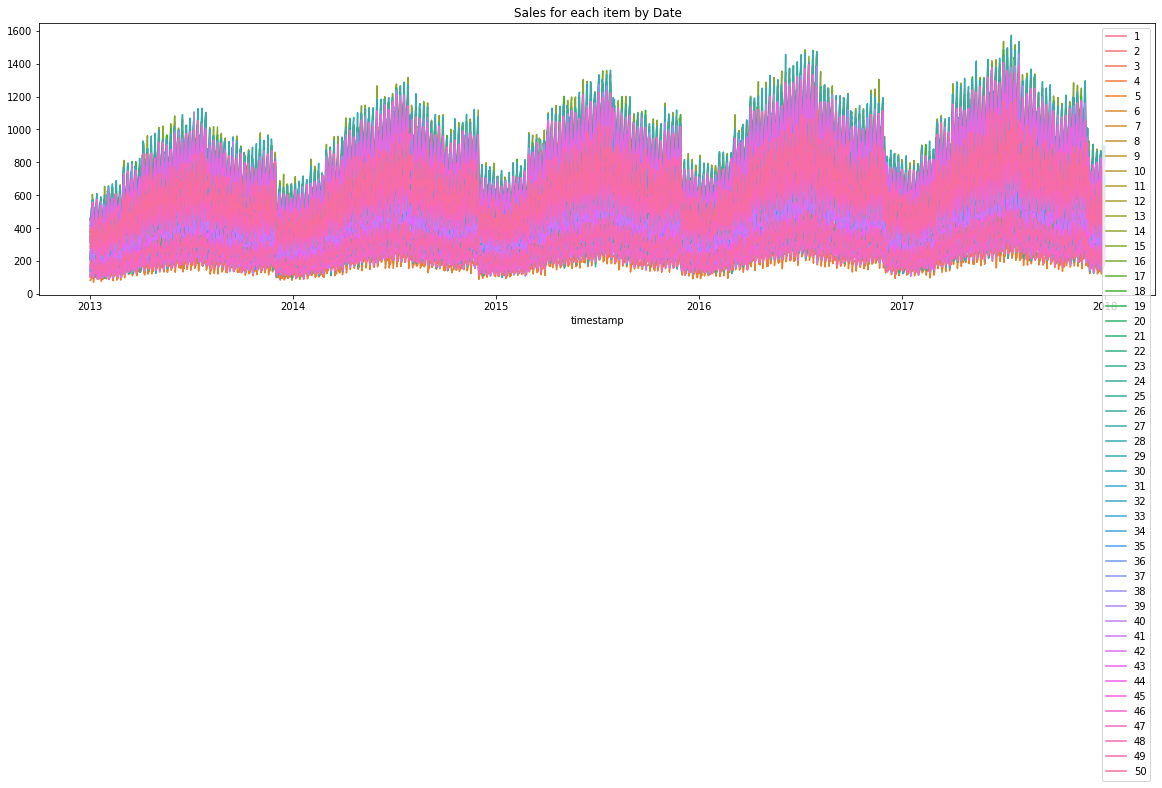

In [18]:
palette = sns.color_palette("Set2")
plt.figure(figsize=(20,5))
graph = sns.lineplot(data=pivot,dashes=False).set_title("Sales for each item by Date")

#### split 5-year training data into 4-year of training and 1-year of testing

In [14]:
four_month_train = train[(train['timestamp'] <= '2016-12-31')]
four_month_train

,timestamp,store_id,item_id,demand
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912630,2016-12-27,10,50,60
912631,2016-12-28,10,50,43
912632,2016-12-29,10,50,68
912633,2016-12-30,10,50,63


In [15]:
one_month_test = train[(train['timestamp'] >= '2017-1-1')]
one_month_test

,timestamp,store_id,item_id,demand
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [16]:
four_month_train.to_csv("four_month_train.csv",index = False)

Now upload the data to the S3 bucket you specified first.

In [17]:
s3 = session.client('s3')
key="four_month_train.csv"
s3.upload_file(Filename="four_month_train.csv", Bucket=bucketName, Key=key)

## 4. Amazon Forecast Workflow

### 4.1 Create Dataset


Forecast Create Dataset action creates an Amazon Forecast dataset. The information about the dataset that you provide helps Forecast understand how to consume the data for model training. This includes the following:

**DataFrequency** - How frequently your historical time-series data is collected. Valid intervals are **Y (Year), M (Month), W (Week), D (Day), H (Hour), 30min (30 minutes), 15min (15 minutes), 10min (10 minutes), 5min (5 minutes), and 1min (1 minute)**. For example, "D" indicates every day and "15min" indicates every 15 minutes.

**Domain** and **DatasetType** - Each dataset has an associated dataset domain and a type within the domain. Amazon Forecast provides a list of predefined domains and types within each domain. For each unique dataset domain and type within the domain, Amazon Forecast requires your data to include a minimum set of predefined fields.

**Schema** - A schema specifies the fields in the dataset, including the field name and data type.

After creating a dataset, you import your training data into it and add the dataset to a dataset group. You use the dataset group to create a predictor. For more information, see howitworks-datasets-groups .

To get a list of all your datasets, use the ListDatasets operation.

In [18]:
project = "anderson_forecasting_4monthtrain_USholi" # Replace this with a unique name here, make sure the entire name is < 30 characters.
datasetName= project+'_ds'
datasetGroupName= project +'_gp'
s3DataPath = "s3://"+bucketName+"/"+key
datasetName

'anderson_forecasting_4monthtrain_USholi_ds'

#### Schema Definition 
More details about Domain and dataset type can be found on the documentation . For this example, we are using **RETAIL domain** with 3 required attributes:


- **item_id** (string):A unique identifier for the item or product that you want to predict the demand for.

- **timestamp** (timestamp)

- **demand** (float) : The number of sales for that item at the timestamp. This is also the target field for which Amazon Forecast generates a forecast.Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.

In [19]:

schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"location",
         "AttributeType":"string"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"demand",
         "AttributeType":"float"
      }, 
   ]
}

In [20]:
DATASET_FREQUENCY = "D" 
TIMESTAMP_FORMAT = "yyyy-MM-dd"

In [21]:
response=forecast.create_dataset(
                    Domain="RETAIL",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
                   )


In [22]:
datasetArn = response['DatasetArn']

In [23]:
forecast.describe_dataset(DatasetArn=response['DatasetArn'])

{'DatasetArn': 'arn:aws:forecast:us-west-2:979749033494:dataset/anderson_forecasting_4monthtrain_USholi_ds',
 'DatasetName': 'anderson_forecasting_4monthtrain_USholi_ds',
 'Domain': 'RETAIL',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'D',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'location', 'AttributeType': 'string'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'},
   {'AttributeName': 'demand', 'AttributeType': 'float'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 11, 2, 3, 11, 7, 470000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 11, 2, 3, 11, 7, 470000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '099d448b-689d-411e-aa97-2a426030d4a6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 02 Nov 2020 03:11:14 GMT',
   'x-amzn-requestid': '099d448b-689d-411

### 4.2 Create Dataset group

In [24]:
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="RETAIL",
                                                              DatasetArns= [datasetArn]
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

In [25]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'anderson_forecasting_4monthtrain_USholi_gp',
 'DatasetGroupArn': 'arn:aws:forecast:us-west-2:979749033494:dataset-group/anderson_forecasting_4monthtrain_USholi_gp',
 'DatasetArns': ['arn:aws:forecast:us-west-2:979749033494:dataset/anderson_forecasting_4monthtrain_USholi_ds'],
 'Domain': 'RETAIL',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 11, 2, 3, 11, 31, 502000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 11, 2, 3, 11, 31, 502000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '6ce8f4fd-a366-4ce2-99fe-ca45fbc67064',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 02 Nov 2020 03:11:35 GMT',
   'x-amzn-requestid': '6ce8f4fd-a366-4ce2-99fe-ca45fbc67064',
   'content-length': '399',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

### 4.3 Create Data Import Job
Brings the data into Amazon Forecast system ready to forecast from raw data. 

In [26]:
datasetImportJobName = "import_job_4month"
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [27]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-west-2:979749033494:dataset-import-job/anderson_forecasting_4monthtrain_USholi_ds/import_job_4month


In [28]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

CREATE_IN_PROGRESS ..............................................
ACTIVE 


In [29]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'DatasetImportJobName': 'import_job_4month',
 'DatasetImportJobArn': 'arn:aws:forecast:us-west-2:979749033494:dataset-import-job/anderson_forecasting_4monthtrain_USholi_ds/import_job_4month',
 'DatasetArn': 'arn:aws:forecast:us-west-2:979749033494:dataset/anderson_forecasting_4monthtrain_USholi_ds',
 'TimestampFormat': 'yyyy-MM-dd',
 'DataSource': {'S3Config': {'Path': 's3://anderson-bucket-myown-test-dataset/four_month_train.csv',
   'RoleArn': 'arn:aws:iam::979749033494:role/ForecastNotebookRole-DeepArPlus'}},
 'FieldStatistics': {'demand': {'Count': 730500,
   'CountDistinct': 203,
   'CountNull': 0,
   'CountNan': 0,
   'Min': '0.0',
   'Max': '214.0',
   'Avg': 50.61022861054072,
   'Stddev': 27.83096369804489},
  'item_id': {'Count': 730500, 'CountDistinct': 50, 'CountNull': 0},
  'location': {'Count': 730500, 'CountDistinct': 10, 'CountNull': 0},
  'timestamp': {'Count': 730500,
   'CountDistinct': 1461,
   'CountNull': 0,
   'Min': '2013-01-01T00:00:00Z',
   'Max': '2016-12-31

### 4.4 Create Predictor with customized Forecast horizon



In [40]:
predictorName= project+'_4_year_training_Holiday'
forecastHorizon = 365
algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

**PerformAutoML**

Whether to perform AutoML. When Amazon Forecast performs AutoML, it evaluates the algorithms it provides and chooses the best algorithm and configuration for your training dataset.
The default value is false . In this case, you are required to specify an algorithm.

**PerformHPO**

Whether to perform hyperparameter optimization (HPO). HPO finds optimal hyperparameter values for your training data. The process of performing HPO is known as running a hyperparameter tuning job.
The default value is false . In this case, Amazon Forecast uses default hyperparameter values from the chosen algorithm.

**NumberOfBacktestWindows** 

The number of times to split the input data. The default is 1. Valid values are 1 through 5.

**BackTestWindowOffset**

The point from the end of the dataset where you want to split the data for model training and testing (evaluation). Specify the value as the number of data points. The default is the value of the forecast horizon. BackTestWindowOffset can be used to mimic a past virtual forecast start date. This value must be greater than or equal to the forecast horizon and less than half of the TARGET_TIME_SERIES dataset length.

**FeaturizationMethodName**

The name of the method. The "filling" method is the only supported method.


In [41]:
create_predictor_response=forecast.create_predictor(PredictorName=predictorName, 
                                                  AlgorithmArn=algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML = False,
                                                  PerformHPO = False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                         "BackTestWindowOffset": 365}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn,
                                                                   "SupplementaryFeatures": [          
                                                                        {             
                                                                            "Name": "holiday",            
                                                                            "Value": "US"         
                                                                        }                   ]   
                                                                   },
                                                  FeaturizationConfig= {"ForecastFrequency": "D",
                                                                        "ForecastDimensions": ["location"],
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "demand", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )

In [42]:
predictorArn=create_predictor_response['PredictorArn']

In [48]:
# start_time = time.time()
# time.sleep(5)
# end_time = time.time()
# print(str(datetime.timedelta(seconds=end_time-start_time)))


0:00:05.005184


In [ ]:
start_time = time.time()

status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_predictor(PredictorArn=predictorArn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

end_time = time.time()
print(str(datetime.timedelta(seconds=end_time-start_time)))

CREATE_PENDING ..
CREATE_IN_PROGRESS .........................................................................................................................................................................................................................................................................................................................................................................................
ACTIVE 
1:04:11.098279


### 4.5 Get Error Metrics

In [44]:
forecast.get_accuracy_metrics(PredictorArn=predictorArn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 8.345047306997067,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.05169136324944221},
       {'Quantile': 0.5, 'LossValue': 0.11233606537494828},
       {'Quantile': 0.1, 'LossValue': 0.048487226597107705}]}},
    {'TestWindowStart': datetime.datetime(2016, 1, 2, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2017, 1, 1, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 500,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 8.34504730699707,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.05169136324944223},
       {'Quantile': 0.5, 'LossValue': 0.11233606537494828},
       {'Quantile': 0.1, 'LossValue': 0.04848722659710769}]}}]}],
 'ResponseMetadata': {'RequestId': 'e2432578-ac33-4f22-8bf1-0a37e43b92e3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {

### 4.6 Create Forecast

Now create a forecast using the model that was trained.

In [46]:
forecastName= project+'_deepAR_forecast_4_month'

create_forecast_response=forecast.create_forecast(ForecastName=forecastName,
                                                  PredictorArn=predictorArn)
forecastArn = create_forecast_response['ForecastArn']

In [47]:
start_time = time.time()
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_forecast(ForecastArn=forecastArn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()
end_time = time.time()
print(str(datetime.timedelta(seconds=end_time-start_time)))


CREATE_IN_PROGRESS ............................................................................................................................................................................................................................................................................................................................................................................................................................................................
ACTIVE 
1:14:48.606146


In [48]:
print(forecastArn)
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecastArn,
    Filters={"item_id":"1"}
)
print(forecastResponse)

arn:aws:forecast:us-west-2:979749033494:forecast/anderson_forecasting_4monthtrain_USholi_deepAR_forecast_4_month
{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2017-01-01T00:00:00', 'Value': 157.88843441009521}, {'Timestamp': '2017-01-02T00:00:00', 'Value': 99.3877363204956}, {'Timestamp': '2017-01-03T00:00:00', 'Value': 114.33149433135986}, {'Timestamp': '2017-01-04T00:00:00', 'Value': 118.02653980255127}, {'Timestamp': '2017-01-05T00:00:00', 'Value': 121.84461784362793}, {'Timestamp': '2017-01-06T00:00:00', 'Value': 139.95975923538208}, {'Timestamp': '2017-01-07T00:00:00', 'Value': 147.37083435058594}, {'Timestamp': '2017-01-08T00:00:00', 'Value': 158.91827297210693}, {'Timestamp': '2017-01-09T00:00:00', 'Value': 101.11342000961304}, {'Timestamp': '2017-01-10T00:00:00', 'Value': 122.99738883972168}, {'Timestamp': '2017-01-11T00:00:00', 'Value': 118.97429275512695}, {'Timestamp': '2017-01-12T00:00:00', 'Value': 130.0857458114624}, {'Timestamp': '2017-01-13T00:00:00', 'Value': 13

### 4.7 Export Forecast

In [49]:
forecastExportName= project+'forecast_export_4_month'

In [50]:
outputPath="s3://"+bucketName+"/output"

In [51]:
forecast_export_response = forecast.create_forecast_export_job(
                                                                ForecastExportJobName = forecastExportName,
                                                                ForecastArn=forecastArn, 
                                                                Destination = {
                                                                   "S3Config" : {
                                                                       "Path":outputPath,
                                                                       "RoleArn": role_arn
                                                                   } 
                                                                }
                                                              )

In [52]:
forecastExportJobArn = forecast_export_response['ForecastExportJobArn']
print(forecastExportJobArn)

arn:aws:forecast:us-west-2:979749033494:forecast-export-job/anderson_forecasting_4monthtrain_USholi_deepAR_forecast_4_month/anderson_forecasting_4monthtrain_USholiforecast_export_4_month


In [53]:
status_indicator = util.StatusIndicator()

while True:
    status = forecast.describe_forecast_export_job(ForecastExportJobArn=forecastExportJobArn)['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

CREATE_PENDING .
CREATE_IN_PROGRESS .........................................
ACTIVE 


In [68]:
s3.list_objects(Bucket=bucketName,Prefix="output")

{'ResponseMetadata': {'RequestId': 'ESFP7HDK4SBQ4PAJ',
  'HostId': '7A6eQ3zK6U3myl5BHYAg6TG9rVkbJlGj910YgqtdJpcnoIbSuvSK978hGJsXUOPSmWwMrbP83mU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '7A6eQ3zK6U3myl5BHYAg6TG9rVkbJlGj910YgqtdJpcnoIbSuvSK978hGJsXUOPSmWwMrbP83mU=',
   'x-amz-request-id': 'ESFP7HDK4SBQ4PAJ',
   'date': 'Thu, 29 Oct 2020 06:50:29 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'output/_CHECK',
   'LastModified': datetime.datetime(2020, 10, 29, 6, 48, 18, tzinfo=tzlocal()),
   'ETag': '"d41d8cd98f00b204e9800998ecf8427e"',
   'Size': 0,
   'StorageClass': 'STANDARD',
   'Owner': {'DisplayName': 'andwct',
    'ID': 'dab3b4e6f60840384cfcf18caf26e46f30da646a494b0817caec46300fa1dce9'}},
  {'Key': 'output/_SUCCESS',
   'LastModified': datetime.datetime(2020, 10, 29, 6, 49, 39, tzinfo=

## 6. Present Solution

A quantile is the value below which a fraction of obmservations in a group falls. For example, a prediction for quantile 0.9 should over-predict 90% of the times.

In [56]:
def download_all_objects_in_folder():
    s3_resource = boto3.resource('s3')
    my_bucket = s3_resource.Bucket('anderson-bucket-myown-test-dataset')
    objects = my_bucket.objects.filter(Prefix='output/')
    for obj in objects:
        path, filename = os.path.split(obj.key)
        my_bucket.download_file(obj.key, filename)

In [58]:
download_all_objects_in_folder()

In [60]:
part0_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part0.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part1_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part1.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part2_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part2.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part3_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part3.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part4_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part4.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part5_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part5.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part6_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part6.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part7_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part7.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part8_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part8.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part9_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part9.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part10_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part10.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part11_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part11.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part12_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part12.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part13_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part13.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part14_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part14.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part15_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part15.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part16_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part16.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part17_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part17.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part18_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part18.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part19_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part19.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part20_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part20.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part21_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part21.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part22_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part22.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])
part23_ = pd.read_csv("cool_11_3/anderson_forecasting_4monthtrain_USholiforecast_export_4_month_2020-11-02T07-46-19Z_part23.csv",usecols = ["item_id","date","location","p50"],parse_dates=["date"])


In [61]:
part0_ = part0_[(part0_['date'] <= '2018-03-31')]
part1_ = part1_[(part1_['date'] <= '2018-03-31')]
part2_ = part2_[(part2_['date'] <= '2018-03-31')]
part3_ = part3_[(part3_['date'] <= '2018-03-31')]
part4_ = part4_[(part4_['date'] <= '2018-03-31')]
part5_ = part5_[(part5_['date'] <= '2018-03-31')]
part6_ = part6_[(part6_['date'] <= '2018-03-31')]
part7_ = part7_[(part7_['date'] <= '2018-03-31')]
part8_ = part8_[(part8_['date'] <= '2018-03-31')]
part9_ = part9_[(part9_['date'] <= '2018-03-31')]
part10_ = part10_[(part10_['date'] <= '2018-03-31')]
part11_ = part11_[(part11_['date'] <= '2018-03-31')]
part12_ = part12_[(part12_['date'] <= '2018-03-31')]
part13_ = part13_[(part13_['date'] <= '2018-03-31')]
part14_ = part14_[(part14_['date'] <= '2018-03-31')]
part15_ = part15_[(part15_['date'] <= '2018-03-31')]
part16_ = part16_[(part16_['date'] <= '2018-03-31')]
part17_ = part17_[(part17_['date'] <= '2018-03-31')]
part18_ = part18_[(part18_['date'] <= '2018-03-31')]
part19_ = part19_[(part19_['date'] <= '2018-03-31')]
part20_ = part20_[(part20_['date'] <= '2018-03-31')]
part21_ = part21_[(part21_['date'] <= '2018-03-31')]
part22_ = part22_[(part22_['date'] <= '2018-03-31')]
part23_ = part23_[(part23_['date'] <= '2018-03-31')]

In [62]:
part0_

,item_id,date,location,p50
0,27,2017-01-01 00:00:00+00:00,6,16.342707
1,27,2017-01-02 00:00:00+00:00,6,11.093513
2,27,2017-01-03 00:00:00+00:00,6,12.772303
3,27,2017-01-04 00:00:00+00:00,6,12.839737
4,27,2017-01-05 00:00:00+00:00,6,13.059702
...,...,...,...,...
8025,42,2017-12-27 00:00:00+00:00,2,38.944515
8026,42,2017-12-28 00:00:00+00:00,2,41.947456
8027,42,2017-12-29 00:00:00+00:00,2,43.452133
8028,42,2017-12-30 00:00:00+00:00,2,47.547398


In [63]:
test = pd.read_csv('test.csv',header = 0,names= ["data_id","timestamp","store_id","item_id"], usecols = ["timestamp","store_id","item_id"],parse_dates=['timestamp'])

In [64]:
    
frames = [part0_, part1_, part2_,part3_,part4_,part5_,part6_,part7_,part8_,part9_,part10_,part11_,part12_,part13_,part14_,part15_,part16_,part17_,part18_,part19_,part20_,part21_,part22_,part23_]
result_dataframe = pd.concat(frames)

In [65]:
result_dataframe

,item_id,date,location,p50
0,27,2017-01-01 00:00:00+00:00,6,16.342707
1,27,2017-01-02 00:00:00+00:00,6,11.093513
2,27,2017-01-03 00:00:00+00:00,6,12.772303
3,27,2017-01-04 00:00:00+00:00,6,12.839737
4,27,2017-01-05 00:00:00+00:00,6,13.059702
...,...,...,...,...
6200,43,2017-12-27 00:00:00+00:00,8,52.028095
6201,43,2017-12-28 00:00:00+00:00,8,54.465942
6202,43,2017-12-29 00:00:00+00:00,8,56.974056
6203,43,2017-12-30 00:00:00+00:00,8,62.314064


In [66]:
one_month_test

,timestamp,store_id,item_id,demand
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [67]:
timestamp = pd.to_datetime(result_dataframe['date']).dt.date
del(result_dataframe["date"])
result_dataframe["timestamp"] = timestamp

In [68]:
result_dataframe

,item_id,location,p50,timestamp
0,27,6,16.342707,2017-01-01
1,27,6,11.093513,2017-01-02
2,27,6,12.772303,2017-01-03
3,27,6,12.839737,2017-01-04
4,27,6,13.059702,2017-01-05
...,...,...,...,...
6200,43,8,52.028095,2017-12-27
6201,43,8,54.465942,2017-12-28
6202,43,8,56.974056,2017-12-29
6203,43,8,62.314064,2017-12-30


In [69]:
result_dataframe.columns = ["item_id", "store_id" ,"sales","timestamp"]

In [70]:
order = ["timestamp", "store_id", "item_id", "sales"]
result_dataframe = result_dataframe[order]
result_dataframe.reset_index()

,index,timestamp,store_id,item_id,sales
0,0,2017-01-01,6,27,16.342707
1,1,2017-01-02,6,27,11.093513
2,2,2017-01-03,6,27,12.772303
3,3,2017-01-04,6,27,12.839737
4,4,2017-01-05,6,27,13.059702
...,...,...,...,...,...
182495,6200,2017-12-27,8,43,52.028095
182496,6201,2017-12-28,8,43,54.465942
182497,6202,2017-12-29,8,43,56.974056
182498,6203,2017-12-30,8,43,62.314064


In [71]:
sorted_result = result_dataframe.sort_values(["item_id","store_id","timestamp"] ,ascending=[True, True, True])

In [72]:
sorted_result = sorted_result.reset_index()


In [73]:
del(sorted_result["index"])

In [74]:
sorted_result

,timestamp,store_id,item_id,sales
0,2017-01-01,1,1,18.989475
1,2017-01-02,1,1,12.252351
2,2017-01-03,1,1,14.445130
3,2017-01-04,1,1,15.112458
4,2017-01-05,1,1,15.709759
...,...,...,...,...
182495,2017-12-27,10,50,62.187714
182496,2017-12-28,10,50,65.701561
182497,2017-12-29,10,50,69.262444
182498,2017-12-30,10,50,72.864700


In [75]:
one_month_test

,timestamp,store_id,item_id,demand
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [91]:
# sorted_result.to_csv("sorted_result_1029.csv",index = True)

In [92]:
# ready_to_test = result_dataframe["sales"]

In [93]:
# ready_to_test.head(10)

0    12.074419
1    13.532046
2    13.928657
3    13.365372
4    14.584154
5    15.849972
6    16.535389
7    11.496982
8    13.082635
9    13.313562
Name: sales, dtype: float64

In [94]:
# ready_to_test.to_csv("ultimate_test_1029_p50_us_holi.csv")

### See if two dataframes match with each other

In [87]:
# template = pd.read_csv("test.csv")
# my_output = pd.read_csv("sorted_result.csv")

In [88]:
# print(template.shape)
# print(my_output.shape)

(45000, 4)
(45000, 5)


In [91]:
# template

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [94]:
# my_output

,Unnamed: 0,timestamp,store_id,item_id,sales
0,0,2018-01-01,1,1,12.691566
1,1,2018-01-02,1,1,15.995275
2,2,2018-01-03,1,1,14.665138
3,3,2018-01-04,1,1,17.725986
4,4,2018-01-05,1,1,17.471785
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,77.624092
44996,44996,2018-03-28,10,50,78.125984
44997,44997,2018-03-29,10,50,82.452652
44998,44998,2018-03-30,10,50,87.588036


In [99]:
# my_output = my_output.rename(columns={'Unnamed: 0': "id", 'timestamp': "date","store_id":"store","item_id":"item"})
# my_output

,id,date,store,item,sales
0,0,2018-01-01,1,1,12.691566
1,1,2018-01-02,1,1,15.995275
2,2,2018-01-03,1,1,14.665138
3,3,2018-01-04,1,1,17.725986
4,4,2018-01-05,1,1,17.471785
...,...,...,...,...,...
44995,44995,2018-03-27,10,50,77.624092
44996,44996,2018-03-28,10,50,78.125984
44997,44997,2018-03-29,10,50,82.452652
44998,44998,2018-03-30,10,50,87.588036


### Graph showing Forecast Result vs ground truth

In [76]:
sorted_result

,timestamp,store_id,item_id,sales
0,2017-01-01,1,1,18.989475
1,2017-01-02,1,1,12.252351
2,2017-01-03,1,1,14.445130
3,2017-01-04,1,1,15.112458
4,2017-01-05,1,1,15.709759
...,...,...,...,...
182495,2017-12-27,10,50,62.187714
182496,2017-12-28,10,50,65.701561
182497,2017-12-29,10,50,69.262444
182498,2017-12-30,10,50,72.864700


In [77]:
one_month_test

,timestamp,store_id,item_id,demand
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [80]:
daily_sales = sorted_result.groupby('timestamp', as_index=False)['sales'].sum()
store_daily_sales = sorted_result.groupby(['store_id', 'timestamp'], as_index=False)['sales'].sum()
item_daily_sales = sorted_result.groupby(['item_id', 'timestamp'], as_index=False)['sales'].sum()

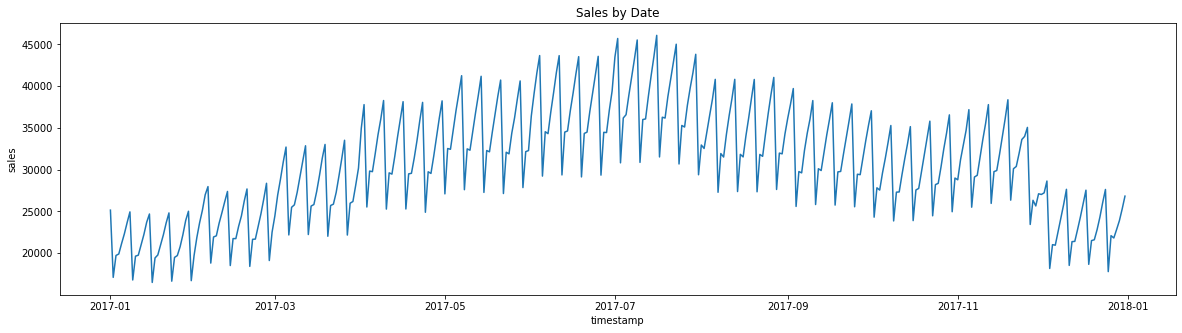

In [84]:
palette = sns.color_palette("mako_r", 6)
plt.figure(figsize=(20,5))
graph = sns.lineplot(data=daily_sales, x="timestamp", y="sales", palette=palette).set_title("Sales by Date")

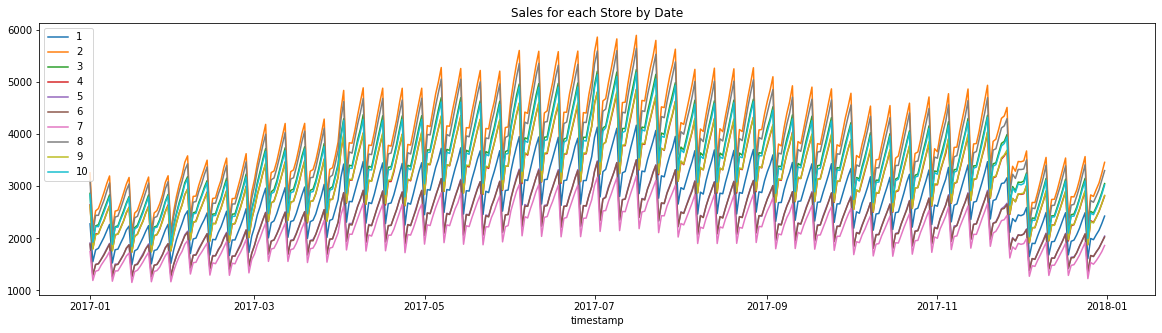

In [85]:
plt.figure(figsize=(20,5))
pivot = store_daily_sales.pivot("timestamp", "store_id", "sales")
graph = sns.lineplot(data=pivot,dashes=False).set_title("Sales for each Store by Date")

In [87]:
daily_sales_one_year = one_month_test.groupby('timestamp', as_index=False)['demand'].sum()
store_daily_sales_one_year = one_month_test.groupby(['store_id', 'timestamp'], as_index=False)['demand'].sum()
item_daily_sales_one_year  = one_month_test.groupby(['item_id', 'timestamp'], as_index=False)['demand'].sum()

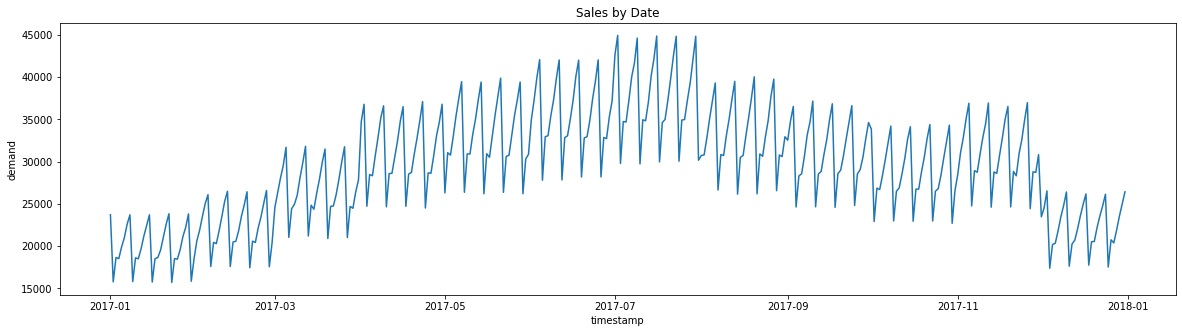

In [90]:
palette = sns.color_palette("mako_r", 6)
plt.figure(figsize=(20,5))
graph = sns.lineplot(data=daily_sales_one_year, x="timestamp", y="demand", palette=palette).set_title("Sales by Date")

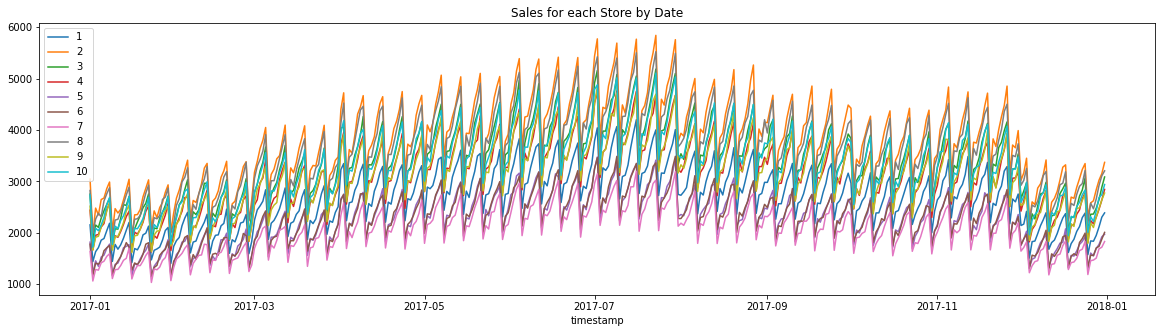

In [91]:
plt.figure(figsize=(20,5))
pivot = store_daily_sales_one_year.pivot("timestamp", "store_id", "demand")
graph = sns.lineplot(data=pivot,dashes=False).set_title("Sales for each Store by Date")

In [94]:
Dataframe_for_line_plot = pd.datasorted_result["sales"]

pandas.core.series.Series

## 7. Cleanup

Once we have completed the above steps, we can start to cleanup the resources we created. All delete jobs, except for `delete_dataset_group` are asynchronous, so we have added the helpful `wait_till_delete` function. 
Resource Limits documented <a href="https://docs.aws.amazon.com/forecast/latest/dg/limits.html">here</a>.

In [ ]:
# Delete forecast export for both algorithms
util.wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecastExportJobArn))

In [ ]:
# Delete forecast
util.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecastArn))

In [ ]:
# Delete predictor
util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictorArn))

In [ ]:
# Delete Import
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ds_import_job_arn))

In [ ]:
# Delete the dataset
util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=datasetArn))

In [ ]:
# Delete Dataset Group
util.wait_till_delete(lambda: forecast.delete_dataset_group(DatasetGroupArn=datasetGroupArn))

In [ ]:
# Delete IAM role
util.delete_iam_role( role_name )